In [1]:
import sys
sys.path.append("..")
from datetime import date
from pathlib import Path
import pickle
from typing import List, Tuple

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Input, Model
import talib

from btc_predictor.datasets import DataReader
from btc_predictor.models import LSTM_Model
from btc_predictor.utils import print_metrics
from btc_predictor.utils import show_plot
from btc_predictor.utils import plot_train_history

tf.random.set_seed(78)
np.random.seed(78)
mpl.rcParams['figure.figsize'] = [16.0, 9.0]
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
data = DataReader(data_file="../btc_predictor/datasets/Bitstamp_BTCUSD_d.csv")
df = data.pd

In [3]:
BTCUSD = df.copy()

BTCUSD['baseline_Close'] = BTCUSD.Close.shift(1)
BTCUSD['log_ret'] = np.log(BTCUSD.Close) - np.log(BTCUSD.Close.shift(1))
BTCUSD['baseline_log_ret'] = np.log(BTCUSD.baseline_Close) - np.log(BTCUSD.baseline_Close.shift(1))
BTCUSD.dropna(inplace=True)
print(f'Total daily data: {BTCUSD.shape[0]} days')

Total daily data: 1973 days


In [4]:
class Config(object):
    """Config object to store training hyperparameters"""
    def __repr__(self):
        return str(self.__dict__)

config = Config()

In [5]:
config.TRAIN_SIZE = 1680
config.VAL_SIZE = 180
config.WINDOW_SIZE = 16
config.BATCH_SIZE= 256
config.EPOCHS = 15
config.EVALUATION_INTERVAL = 64
config.VALIDATION_STEPS = 64
config.WALK_FORWARD = 30

# 1. Univariate RNN Model

Our best statistical model is ARIMA(5, 1, 1) was trained using 330 days of closing log returns and forcasted on forward 7 days. To make models comparable, we will also try to forecast the forward 7 days log returns. We tried to use 0th order differencing but the model failed to learn. Our ARIMA model provided the hit of using 1st order differencing thus we will apply the same thing.

In [6]:
time_series_data = np.diff(BTCUSD['log_ret'].to_numpy()).astype('float32')
train = time_series_data[:config.TRAIN_SIZE]
val = time_series_data[config.TRAIN_SIZE:config.VAL_SIZE+config.TRAIN_SIZE]
test = time_series_data[config.VAL_SIZE+config.TRAIN_SIZE:]

## 1.1 Data Preprocessing using tf.data

In [7]:
train_tfds = data.create_tfds_from_np(data=train,
                                      window_size=config.WINDOW_SIZE,
                                      batch_size=config.BATCH_SIZE)
val_tfds = data.create_tfds_from_np(data=val,
                                    window_size=config.WINDOW_SIZE,
                                    batch_size=config.BATCH_SIZE)
test_tfds = data.create_tfds_from_np(data=test,
                                     window_size=config.WINDOW_SIZE,
                                     batch_size=1)

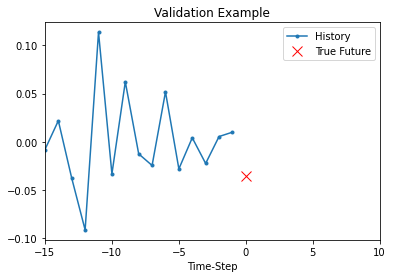

In [8]:
for x, y in val_tfds.take(1):
    plot = show_plot(plot_data=[x[0].numpy(), y[0].numpy()],
                    title='Validation Example')
    plot.show()

## 1.2 Simple RNN Model

In [9]:
lstm_model = LSTM_Model(input_shape=(config.WINDOW_SIZE-1, 1),
                        dropout=0.4,
                        num_forward=1,)
lstm_model.compile(optimizer='adam',
                   loss='mse')

In [10]:
train_history = lstm_model.fit(train_tfds,
                               epochs=config.EPOCHS,
                               steps_per_epoch=config.EVALUATION_INTERVAL,
                               validation_data=val_tfds,
                               validation_steps=config.VALIDATION_STEPS)


Epoch 1/15
64/64 [==============================] - 1s 12ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 2/15
64/64 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 3/15
64/64 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 4/15
64/64 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 5/15
64/64 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 6/15
64/64 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 7/15
64/64 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 8/15
64/64 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 9/15
64/64 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 10/15
64/64 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 11/15
64/64 

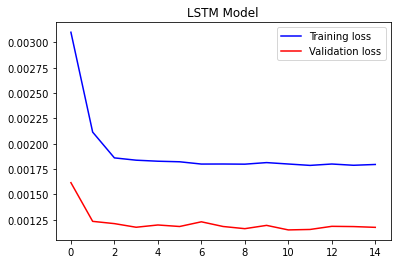

In [11]:
train_val_plot = plot_train_history(history=train_history, title="LSTM Model")
train_val_plot.show();

## 1.3 Model Evaluation

After training for 10 epochs, validation loss hovers around 0.001, so we cut it short. Now let's look at how the model behaves in walk foward and generate metrics for comparison with our baseline, AR(16), and ARIMA(5, 1, 1) in terms of both RMSE and directional accuracy.

In [12]:
test_y_true = np.array([])
test_y_pred = np.array([])
for x, y in test_tfds.take(config.WALK_FORWARD):
    test_y_true = np.append(test_y_true, y[0].numpy())
    test_y_pred = np.append(test_y_pred, lstm_model.predict(x)[0])

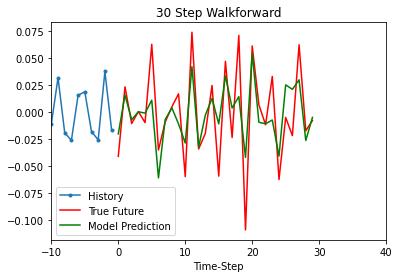

In [13]:
plot = show_plot(plot_data=[test[:10], test_y_true, test_y_pred],
                 delta=config.WALK_FORWARD,
                 title=f'{config.WALK_FORWARD} Step Walkforward',
                 labels=['History', 'True Future', 'Model Prediction'],
                 marker=['.-', 'r-', 'g-'])
plot.show();

In [14]:
print_metrics(y_true=test_y_true, y_pred=test_y_pred)

Prediction RMSE: 0.0285, directional accuracy: 0.8000


In [15]:
lstm_model.save(f'saved_model/lstm_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/lstm_model\assets
